# NeRFの推論

## ロード/ディレクトリ設定

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from nerf_tutorial.intrinsics import Intrinsic
from nerf_tutorial.extrinsics import PoseExtrinsic, RVecExtrinsic
from nerf_tutorial.nerf import NeRFConfig, NeRF, NeRFLoss
from nerf_tutorial.visualization_utils import IpywidgetsRenderer
from nerf_tutorial.nerf_utils import render_nerf, extract_pointcloud

In [2]:
base_dir = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_dir, "results", "original_nerf")

## NeRFの呼び出し

In [3]:
device = torch.device("cuda:0")

# NeRF
config = NeRFConfig()
nerf = NeRF(**config.nerf_kwargs())

# camera parameters
ckpt = torch.load(
    os.path.join(out_dir, "ckpt_last"), 
    map_location="cpu"
)["state_dict"]
pose = ckpt["extrinsic.pose"].numpy()
image_wh = ckpt["intrinsic.image_wh"].numpy()
fs = ckpt["intrinsic.fs"].numpy()
cxcy = ckpt["intrinsic.cxcy"].numpy()

intrinsic = Intrinsic(
    image_wh, focals=fs, cxcy=cxcy, **config.intrinsic_kwargs())

if config.nerfmm:
    extrinsic = RVecExtrinsic(
        len(pose), pose, **config.extrinsic_kwargs())
else:
    extrinsic = PoseExtrinsic(
        len(pose), pose, **config.extrinsic_kwargs())

loss_func = NeRFLoss(nerf, intrinsic=intrinsic, extrinsic=extrinsic)
loss_func.load_state_dict(ckpt)
loss_func.to(device)

NeRFLoss(
  (nerf): NeRF(
    (rf_c): RadianceField(
      (layer0): Linear(in_features=60, out_features=256, bias=True)
      (layer1): Linear(in_features=256, out_features=256, bias=True)
      (layer2): Linear(in_features=256, out_features=256, bias=True)
      (layer3): Linear(in_features=256, out_features=256, bias=True)
      (layer4): Linear(in_features=256, out_features=256, bias=True)
      (layer5): Linear(in_features=316, out_features=256, bias=True)
      (layer6): Linear(in_features=256, out_features=256, bias=True)
      (layer7): Linear(in_features=256, out_features=256, bias=True)
      (sigma): Linear(in_features=256, out_features=1, bias=True)
      (layer8): Linear(in_features=256, out_features=256, bias=True)
      (layer9): Linear(in_features=280, out_features=128, bias=True)
      (layer10): Linear(in_features=128, out_features=128, bias=True)
      (layer11): Linear(in_features=128, out_features=128, bias=True)
      (layer12): Linear(in_features=128, out_feature

## レンダリング

In [4]:
idx = 0
camera_parameters = {
    "w": 800,
    "h": 600,
    "pose": extrinsic[[idx]],
    "device": device,
}

W, H = image_wh
cx, cy = cxcy
fx, fy = fs

camera_parameters["cx"] = cx / W * camera_parameters["w"]
camera_parameters["cy"] = cy / H * camera_parameters["h"]
camera_parameters["fx"] = fx / W * camera_parameters["w"]
camera_parameters["fy"] = fy / H * camera_parameters["h"]

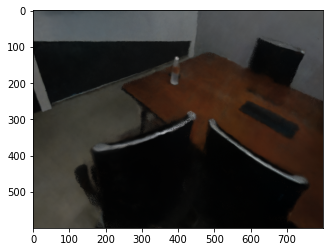

In [5]:
# render single image
img = render_nerf(nerf, camera_parameters, only_coarse=False)
plt.imshow(img)
plt.show()

In [6]:
# renderer with controller
IpywidgetsRenderer(nerf, camera_parameters, only_coarse=True)

## 点群抽出

In [7]:
pcd = extract_pointcloud(
    nerf, num_grid_edge=300, sigma_threshold=50, device=device)
pcd.to_file(os.path.join(out_dir, "nerf_repro.ply"))